In [6]:
## running once
%load_ext autoreload
%autoreload 2

# from julia.api import Julia
# jl = Julia(compiled_modules=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
from typing import List, Tuple, Optional
from toolz.curried import *

def wktlinestring2lonlat(gps_wkt: str) -> Tuple[np.array, np.array]:
    points = pipe(re.search(r"LINESTRING\s?\((.*?)\)", gps_wkt).group(1), 
                  lambda x: re.split(", | |,", x), 
                  map(float), list)
    return np.asarray(points[0::2]), np.asarray(points[1::2])

def lonlat2wktlinestring(lon: np.array, lat: np.array) -> str:
    gpsstr = pipe([f"{x} {y}" for x, y in zip(lon, lat)], lambda xs: ", ".join(xs))
    return "LINESTRING (" + gpsstr + ")"

In [4]:
from bokeh.plotting import figure, output_notebook, output_file, show
import numpy as np
import datashader
from bokeh.tile_providers import STAMEN_TERRAIN, STAMEN_TONER_BACKGROUND, get_provider
from bokeh.models import (
    Range1d, WMTSTileSource, ColumnDataSource, HoverTool
)

output_notebook()
tile_provider = get_provider(STAMEN_TERRAIN)

def plot_gps(lon: np.array, lat: np.array, line_width=0.1):
    plot_width  = int(600)
    plot_height = int(plot_width//1.2)
    x, y = datashader.utils.lnglat_to_meters(lon, lat)
    x_range = Range1d(start=x.min()-200, end=x.max()+200, bounds=None)
    y_range = Range1d(start=y.min()-200, end=y.max()+200, bounds=None)
    p = figure(tools='wheel_zoom,pan,reset,hover,save', x_range=x_range, y_range=y_range,
               plot_width=plot_width, plot_height=plot_height)
    p.add_tile(tile_provider)
    
    p.line(x=x, y=y, line_width=line_width)
    p.circle(x=x, y=y, size=5, fill_color="#F46B42", line_color=None, line_width=1.5)
    return p

def plot_wkt(wkt: str, line_width=0.1):
    lon, lat = wktlinestring2lonlat(wkt)
    return plot_gps(lon, lat, line_width)

Loading BokehJS ...

In [4]:
from julia.Trips import readtripsjld2

In [2]:
#trips = readtripsjld2("/home/xiucheng/Github/mm/trips/output/gps_20161101.jld2")
#print(len(trips))
trips2 = readtripsjld2("/home/xiucheng/Github/mm/trips/output/gps_20161101.jld2")

In [5]:
trips2[1].validspeed

True

In [6]:
city = "chengdu"
edges = gpd.read_file(f"../../data/cities/{city}/edges.shp")
nodes = gpd.read_file(f"../../data/cities/{city}/nodes.shp")

nodes.set_index('osmid', inplace=True, drop=True)
edges.set_index(['u', 'v', 'key'], inplace=True, drop=True)

In [243]:
# 162
trip = trips2[129199]
print(trip.state)
print(trip.validspeed)

True
True


<AxesSubplot:>

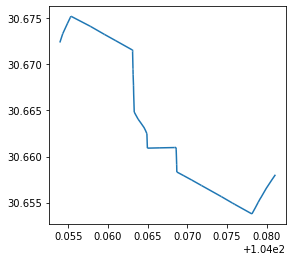

In [244]:
edges[edges.fid.isin(trip.cpath)].plot()

In [232]:
#df = pd.read_csv("/home/xiucheng/Github/mm/trips/output/trips_150104.csv", header=0, delimiter=";", nrows=2000)

In [245]:
show(plot_gps(trip.lon[::2], trip.lat[::2], 1.2))

In [182]:
#plon, plat = wktlinestring2lonlat(trip.pgeom)
#show(plot_gps(plon[::3], plat[::3], 1.2))

In [246]:
mlon, mlat = wktlinestring2lonlat(trip.mgeom)
show(plot_gps(mlon[:], mlat[:], 1.2))

In [91]:
import osmnx as ox
from geopandas import GeoDataFrame
from networkx import MultiDiGraph
    
def plot_route(G: MultiDiGraph, nodes: GeoDataFrame, route: List[int],
               center_node: Optional[int]=None, dist=300) -> None:
    n = len(route)
    if center_node is None: center_node = route[n//2]
    y, x = nodes.loc[center_node, ['y', 'x']].values
    bbox = ox.utils_geo.bbox_from_point(point=(y, x), dist=dist)
    fig, ax = ox.plot_graph_route(G, route, bbox=bbox, route_linewidth=3, node_size=.5)
                                  
def get_route(edges: GeoDataFrame, cpath) -> List[int]:
    getuv = lambda fid: edges[edges.fid == fid].index[0][0]
    return list(map(getuv, cpath)) + [edges[edges.fid == cpath[-1]].index[0][1]]

In [92]:
G = ox.utils_graph.graph_from_gdfs(nodes, edges)

In [195]:
route = get_route(edges, trip.cpath)

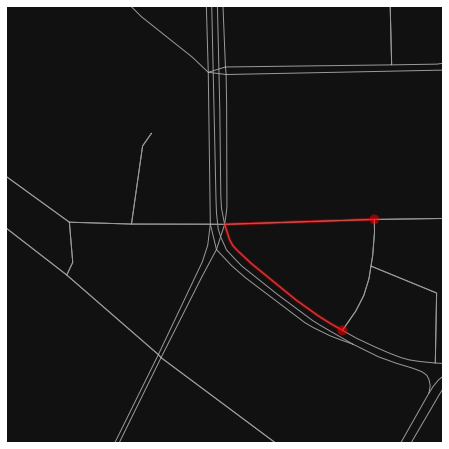

In [198]:
plot_route(G, nodes, route, dist=300)